https://h-gens.github.io/automated-drawing-of-the-mos-band-diagram.html

Ev=0.0000V, Ec=1.1245V, Ei=0.5585V, Ef=0.0881V
NMOS Pwell conc:5.9900e+17cm-3, EF=0.0956V, Difference:0.0074V
Vgb = 1.1349V, psiox = 0.8610V, psis = 0.4704V


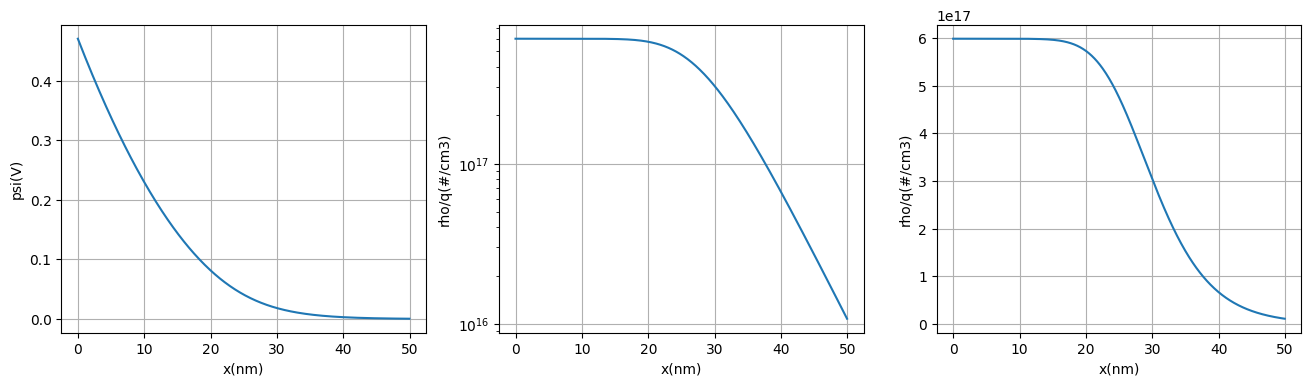

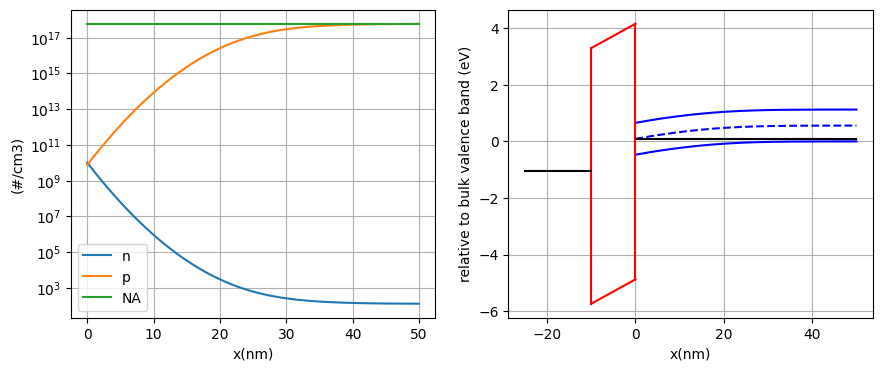

In [8]:
from constant import q,m0,e0,hbar,mn,e_si,k,kB,mp,kT_q,Eg,Nc,Nv,ni,mun,mup,e_ox
import numpy as np, matplotlib.pyplot as plt 
from scipy.integrate import quad

# user defined settings/physical constants/material parameters
T=300; tox=10e-9*100; ND=1e15; NA=6e17; CBO=3.5; VBO=4.4; es=e_si; eox=e_ox; chi_s=4.17; phi_m=5.01
Eg=Eg(T); Nv=Nv(T); Nc=Nc(T); ni=ni(T); kT=k*T

# energy level
Ev=0; Ec=Eg; Ei=kT*np.log(ni/Nc)+Ec

# get the fermi level in the bulk where there is no band-bending.
n=lambda Ef: Nc*np.exp(-(Ec-Ef)/kT)
p=lambda Ef: Nv*np.exp(-(Ef-Ev)/kT)
func=lambda Ef: p(Ef)-n(Ef)+ND-NA

# use bisection search method
def my_bisection(f, a, b, tol): 
    if np.sign(f(a)) == np.sign(f(b)): raise Exception("The scalars a and b do not bound a root")
    while abs(b - a) > tol: 
        m = (a + b)/2
        if np.abs(f(m)) < tol: return m
        elif np.sign(f(a)) == np.sign(f(m)): a=m
        else: b=m
    return(a+b)/2

# Fermi level calculation from charge neutrality
Ef=my_bisection(func, Ev, Ec, 1e-10)
print("Ev=%0.4fV, Ec=%0.4fV, Ei=%0.4fV, Ef=%0.4fV" % (Ev,Ec,Ei,Ef))

# calculate the effective compensated doping densities
if NA > ND: 
    NA = NA - ND
    ND=0
    EF=Ei-kT*np.log(NA/ni)
    device_type="NMOS"
    print("NMOS Pwell conc:%0.4ecm-3, EF=%0.4fV, Difference:%0.4fV" % (NA, EF, EF-Ef))
else:          
    ND = ND - NA;     
    NA=0
    EF=Ei+kT*np.log(ND/ni)
    device_type="PMOS"
    print("PMOS Nwell conc:%0.4ecm-3, EF=%0.4fV, Difference:%0.4fV" % (ND, EF, EF-Ef))

# computed semiconductor work function(energy from vaccum to Ef)
phi_s=chi_s+Ec-Ef; phi_ms=phi_m-phi_s; Vfb=phi_ms; Cox=eox*e0/tox

# define the SPE(surface potential equation) at equilibrium carrier concentrations
no=Nc*np.exp(-(Ec-Ef)/kT)
po=Nv*np.exp(-(Ef-Ev)/kT) 
f=lambda psis: kT*po*(np.exp(-psis/kT)-1)+kT*no*(np.exp(psis/kT)-1)+psis*(NA-ND)
Qs=lambda psis: -np.sign(psis)*np.sqrt(2*q*e0*es*f(psis))
SPE=lambda psis: Vfb+psis-Qs(psis)/Cox

Efield=lambda psi: np.sign(psi)*np.sqrt(2*q/(es*e0)*f(psi))

# x-computation functions
integrand_x=lambda psi: 1/Efield(psi)
def compute_x_vs_psi(psis):
    if psis==0:
        x=np.linspace(1,150,101)
        psi=np.zeros_like(x)
        return x, psi
    psi=np.sign(psis)*np.logspace(np.log10(np.abs(psis)), np.log10(np.abs(psis * 1e-3)), 501)
    x = np.array([quad(integrand_x, value, psis)[0] for value in psi])
    return x, psi

# choose a potential to plot
#psis = Ev - Ef                    # (very) strong accumulation
#psis = 0                          # flatband
psis = Ei - Ef                    # weak inversion
#psis = 2 * (Ei - Ef)              # strong inversion
#psis = 2 * (Ei - Ef) + 3* kT   # stronger inversion
#psis = Ec - Ef                    # (very) strong inversion 
#psis = my_bisection(SPE, Ev - Ef, Ec - Ef,1e-10 ) # zero gate-bulk bias

x,psi=compute_x_vs_psi(psis)
x = x*1e7

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.plot(x,psi), plt.xlabel('x(nm)'), plt.ylabel('psi(V)'), plt.grid(True)

n=no*np.exp(psi/kT)
p=po*np.exp(-psi/kT)
rho=p-n+ND-NA

plt.subplot(132)
plt.semilogy(x, np.abs(rho)), plt.xlabel('x(nm)'), plt.ylabel('rho/q(#/cm3)'), plt.grid(True)

plt.subplot(133)
plt.plot(x, np.abs(rho)), plt.xlabel('x(nm)'), plt.ylabel('rho/q(#/cm3)'), plt.grid(True)

plt.figure(figsize=(16,4))
plt.subplot(131)
plt.xlabel('x(nm)'), plt.ylabel('(#/cm3)'), plt.grid(True)
plt.semilogy(x, n, label='n')
plt.semilogy(x, p, label='p')
if device_type == 'NMOS':
    plt.semilogy(x, NA+0*x, label='NA')
else:
    plt.semilogy(x, ND+0*x, label='ND')
plt.legend()

plt.subplot(132)
# compute the corresponding Vgb value
Vgb = SPE(psis)
toxnm = tox*1e7

# create figure, label axes, turn grid on
plt.xlabel('x(nm)'), plt.ylabel('relative to bulk valence band (eV)'), plt.grid(True)

# get psiox from the potential balance equation (see SPE derivation)
psiox = Vgb - psis - phi_ms

# plot the conduction/intrinsic/valence bands
plt.plot(x, Ev - psi, 'b')
plt.plot(x, Ei - psi, 'b--')
plt.plot(x, Ec - psi, 'b')
# plot the fermi level
plt.plot(x, 0 * x + Ef, 'k')

# plot the SiO2 bands
plt.plot([0, 0], [Ev - psis - VBO, Ec - psis + CBO], 'r')
plt.plot([-toxnm, -toxnm],[Ev - psis - VBO - psiox, Ec - psis + CBO - psiox], 'r')
plt.plot([-toxnm, 0], [Ev - psis - VBO - psiox, Ev - psis - VBO], 'r')
plt.plot([-toxnm, 0], [Ec - psis + CBO - psiox, Ec - psis + CBO], 'r')

# plot the gate's Fermi level
plt.plot([-toxnm - 15, -toxnm],[Ef - phi_ms - psis - psiox, Ef - phi_ms - psis - psiox],'k')
plt.grid(True, which='both', linestyle='-', linewidth=0.8)
print('Vgb = %0.4fV, psiox = %0.4fV, psis = %0.4fV' % (Vgb, psiox, psis))

plt.show()
